## Counter Metric Analysis

In [1]:
# install and load necessary packages
!pip install seaborn

import pyspark
from datetime import datetime
import seaborn as sns
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

print('Python version ' + sys.version)
print('Spark version: ' + pyspark.__version__)

Python version 3.6.3 (default, Mar 20 2018, 13:50:41) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-16)]
Spark version: 2.2.1


### Establish Connection to Spark Cluster

set configuration so that the Spark Cluster communicates with Ceph and reads a chunk of data.

In [2]:
import string 
import random

# Set the configuration
# random string for instance name
inst = ''.join(random.choices(string.ascii_uppercase + string.digits, k=4))
AppName = inst + ' - Ceph S3 Prometheus JSON Reader'
conf = pyspark.SparkConf().setAppName(AppName).setMaster('spark://spark-cluster.dh-prod-analytics-factory.svc:7077')
print("Application Name: ", AppName)

# specify number of nodes need (1-5)
conf.set("spark.cores.max", "8")

# specify Spark executor memory (default is 1gB)
conf.set("spark.executor.memory", "4g")

# Set the Spark cluster connection
sc = pyspark.SparkContext.getOrCreate(conf) 

# Set the Hadoop configurations to access Ceph S3
import os
(ceph_key, ceph_secret, ceph_host) = (os.getenv('DH_CEPH_KEY'), os.getenv('DH_CEPH_SECRET'), os.getenv('DH_CEPH_HOST'))
ceph_key = 'DTG5R3EEWN9JBYJZH0DF'
ceph_secret = 'pdcEGFERILlkRDGrCSxdIMaZVtNCOKvYP4Gf2b2x'
ceph_host = 'http://storage-016.infra.prod.upshift.eng.rdu2.redhat.com:8080'
sc._jsc.hadoopConfiguration().set("fs.s3a.access.key", ceph_key) 
sc._jsc.hadoopConfiguration().set("fs.s3a.secret.key", ceph_secret) 
sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", ceph_host) 

#Get the SQL context
sqlContext = pyspark.SQLContext(sc)

Application Name:  3TLC - Ceph S3 Prometheus JSON Reader


## Generate Counter Data
* l1 = bernoulli
* l2 = increasing by 1 from 1 to 100
* l3 = random reset to zero
* l4 = random increase and random resets

In [3]:
import numpy as np
import copy

l1 = np.random.binomial(1, 0.5, 100).tolist()
l2 = np.arange(1,100).tolist()

l3 = []
num = 0

toggle = np.random.randint(1,40)
for i in range(1,100):
    num = num + 1
    if i % toggle == 0:
        toggle = np.random.randint(1,40)
        num = 0
    l3.append(num)
    
l4 = []
num = 0

toggle = np.random.randint(1,40)
for i in range(1,100):
    num = num + np.random.randint(1,6)
    if i % toggle == 0:
        toggle = np.random.randint(1,40)
        num = 0
    l4.append(num)

    
l = zip(l1,l2,l3,l4)

df_c = sqlContext.createDataFrame(l)

### Generate Data with Anomalies from Clean Data

In [4]:
l1_A = copy.copy(l1)
l1_A[24] = -1


l2_A = copy.copy(l2)
l2_A[94] = -1

l3_A = copy.copy(l3)
l3_A[36] = 32

l4_A = copy.copy(l4)
l4_A[57] = -10


l_A = zip(l1_A,l2_A,l3_A,l4_A)

df_c_A = sqlContext.createDataFrame(l_A)

In [5]:
df_c.printSchema()

root
 |-- _1: long (nullable = true)
 |-- _2: long (nullable = true)
 |-- _3: long (nullable = true)
 |-- _4: long (nullable = true)



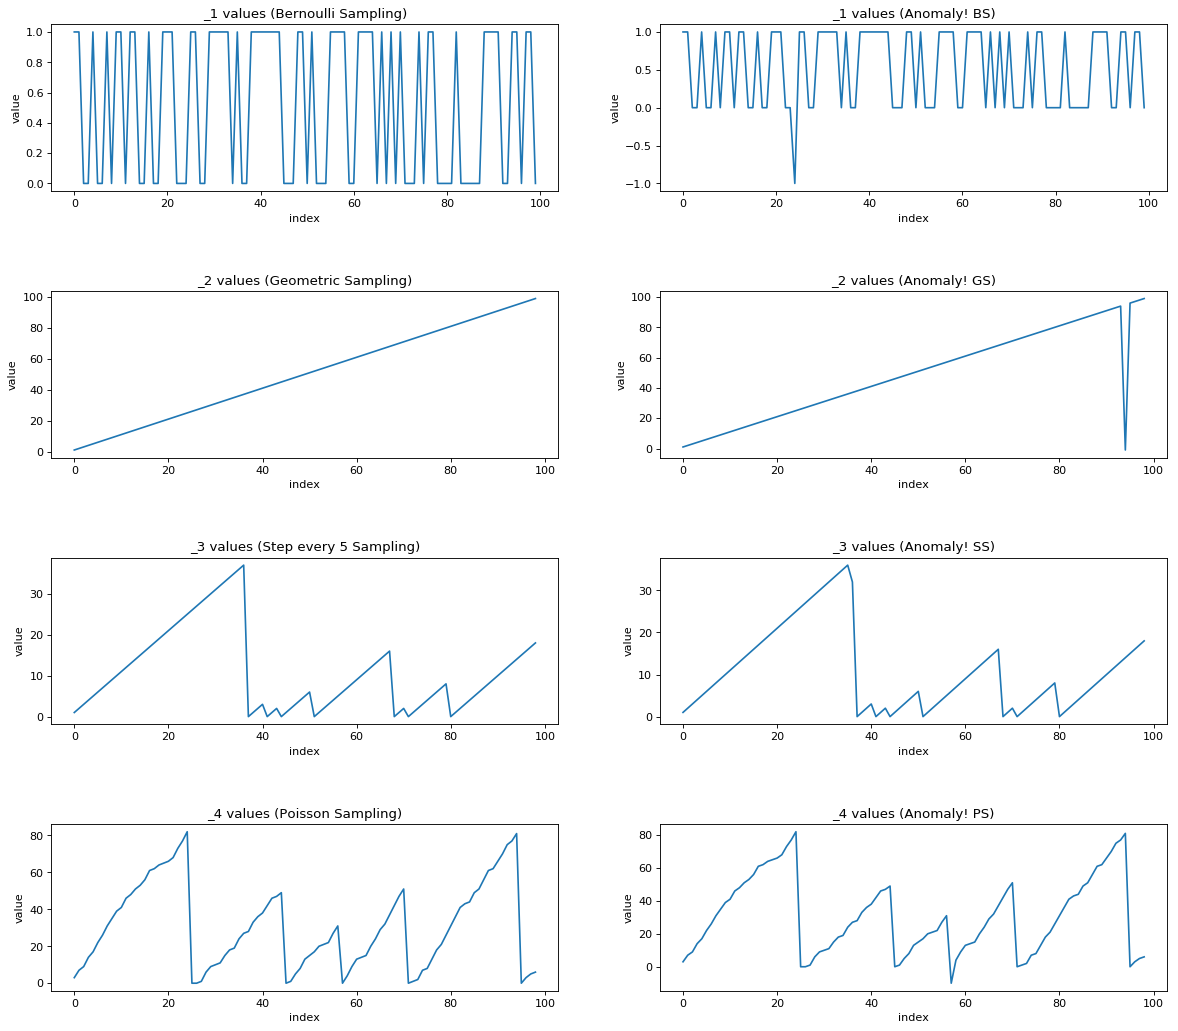

In [6]:
def plot_list(l, title):
    plt.plot(l)
    plt.xlabel("index")
    plt.ylabel("value")
    plt.title(title)

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=.6)
    
plt.subplot(421)
plot_list(l1,"_1 values (Bernoulli Sampling)")

plt.subplot(423)
plot_list(l2,"_2 values (Geometric Sampling)")

plt.subplot(425)
plot_list(l3,"_3 values (Step every 5 Sampling)")

plt.subplot(427)
plot_list(l4,"_4 values (Poisson Sampling)")



plt.subplot(422)
plot_list(l1_A,"_1 values (Anomaly! BS)")

plt.subplot(424)
plot_list(l2_A,"_2 values (Anomaly! GS)")

plt.subplot(426)
plot_list(l3_A,"_3 values (Anomaly! SS)")

plt.subplot(428)
plot_list(l4_A,"_4 values (Anomaly! PS)")


plt.show()




## Generate Gauge Data
* l1 = bernoulli
* l2 = geometric
* l3 = random integer from 1 to 25
* l4 = poisson
* l5 = seasonality example 1
* l6 = seasonality example 2

In [7]:
import numpy as np
import copy

l1 = np.random.binomial(1, 0.5, 100).tolist()
l2 = np.random.geometric(0.25, 100).tolist()
l3 = []
num = np.random.randint(1,25)

for i in range(1,100):
    if i % 5 == 0:
        num = np.random.randint(1,25)
    l3.append(num)
l4 = []
l4 = np.random.poisson(5,100).tolist()

l5 = []
val = 10
for i in range(1,100):
    change_val = 8# + int(np.random.randint(-1,1))
    if i%change_val == 0:
        val = -val
    val = val + float(np.random.normal(0,1,1))
    l5.append(val)
    
l6 = []
val = 10
for i in range(1,100):
    change_val = 8 + int(np.random.randint(-1,1))
    if i%change_val == 0:
        val = -val
    val = val + float(np.random.normal(0,1,1))
    l6.append(val)
    
l = zip(l1,l2,l3,l4,l5,l6)
print(l)
df_g = sqlContext.createDataFrame(l)

In [8]:
df_g.printSchema()

root
 |-- _1: long (nullable = true)
 |-- _2: long (nullable = true)
 |-- _3: long (nullable = true)
 |-- _4: long (nullable = true)
 |-- _5: double (nullable = true)
 |-- _6: double (nullable = true)



### Generate Data with Anomalies from Clean Data

In [9]:
l1_A = copy.copy(l1)
l1_A[24] = -1


l2_A = copy.copy(l2)
l2_A[94] = -1

l3_A = copy.copy(l3)
l3_A[36] = 32

l4_A = copy.copy(l4)
l4_A[57] = -10

l5_A = copy.copy(l5)
l5_A[36] = float(-12)
    
l6_A = copy.copy(l6)
l6_A[57] = float(-12)

l_A = zip(l1_A,l2_A,l3_A,l4_A,l5_A,l6_A)

df_g_A = sqlContext.createDataFrame(l_A)

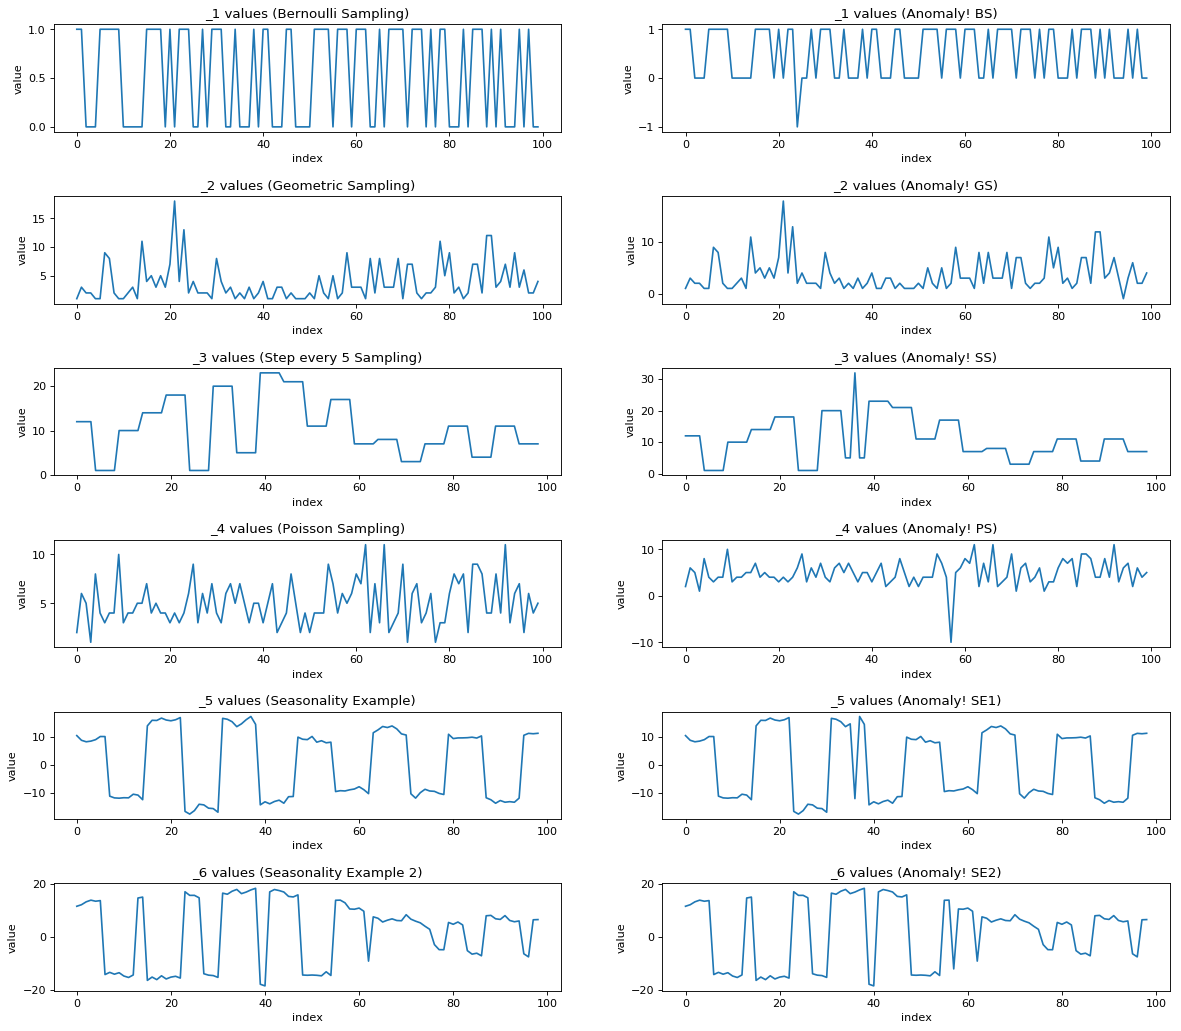

In [10]:
def plot_list(l, title):
    plt.plot(l)
    plt.xlabel("index")
    plt.ylabel("value")
    plt.title(title)

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=.6)
    
plt.subplot(621)
plot_list(l1,"_1 values (Bernoulli Sampling)")


plt.subplot(623)
plot_list(l2,"_2 values (Geometric Sampling)")

plt.subplot(625)
plot_list(l3,"_3 values (Step every 5 Sampling)")

plt.subplot(627)
plot_list(l4,"_4 values (Poisson Sampling)")

plt.subplot(629)
plot_list(l5,"_5 values (Seasonality Example)")

plt.subplot(6,2,11)
plot_list(l6,"_6 values (Seasonality Example 2)")



plt.subplot(622)
plot_list(l1_A,"_1 values (Anomaly! BS)")

plt.subplot(624)
plot_list(l2_A,"_2 values (Anomaly! GS)")

plt.subplot(626)
plot_list(l3_A,"_3 values (Anomaly! SS)")

plt.subplot(628)
plot_list(l4_A,"_4 values (Anomaly! PS)")

plt.subplot(6,2,10)
plot_list(l5_A,"_5 values (Anomaly! SE1)")

plt.subplot(6,2,12)
plot_list(l6_A,"_6 values (Anomaly! SE2)")

plt.show()




## Boolean-valued Data Anomaly Detection
We extend the meaning of boolean-valued data to mean any time series data that takes no greater than 2 possible values.

*Toy Example: Bernoulli Sampling*

If the data is Boolean-valued, we can do 2 types of anomaly detection:
1. Detect values that are not our high and low values
2. Detect if behavior is either too eratic or too constant

**Detect values that are not our high and low values**

In [11]:
# return true if time series is boolean
def bool_valued(df,col_name):
    result = df.groupBy(col_name).count()
    if result.count() <= 2:
        return True
    return False

# get high and low vals
def get_vals(df, col_name):
    vals = np.array(df.groupBy(col_name).count().select(col_name).collect())
    vals = set(map(int, vals))
    return vals

# return all values that are in the data but not given by vals
def find_bool_data_anomaly(df,col_name, vals):
    sample_vals = get_vals(df, col_name)
    # take the symmetric difference of the data and the vals in the two sets
    extra_vals = sample_vals.symmetric_difference(vals.intersection(sample_vals))
    return extra_vals


In [12]:
print("=== Counter Data Set")
if bool_valued(df_c, "_1"):
    vals = get_vals(df_c, "_1")
    print("found anomalous values in df_A: ",find_bool_data_anomaly(df_c_A,"_1", vals))  
    
    
print("=== Gauge Data Set")
if bool_valued(df_g, "_1"):
    vals = get_vals(df_g, "_1")
    print("found anomalous values in df_A: ",find_bool_data_anomaly(df_g_A,"_1", vals))  

=== Counter Data Set
found anomalous values in df_A:  {-1}
=== Gauge Data Set
found anomalous values in df_A:  {-1}


**Detect if behavior is either too eratic or too constant**

* Streak: How long the data value remains constant

In [13]:
# return array of all streaks in data
def get_streaks(df, col_name):
    prev = 0
    cnt = 1
    streaks = []
    for i in df.select(col_name).collect():
        val = i[0]
        if (val - prev) == 0:
            cnt = cnt + 1
        else:
            streaks.append(val)
            cnt = 1
    return streaks
            
# return min and max streak lengths
def get_min_max_streak(df, col_name):
    stk = get_streaks(df, col_name)
    return min(stk), max(stk), np.std(stk)

# alert if we have found a streak smaller or larger than usual
def detect_anomaly_streak(df1, df2, col_name):
    min_cnt, max_cnt, std_cnt = get_min_max_streak(df1, col_name)
    prev = 0
    cnt = 1
    for i in df2.select(col_name).collect():
        val = i[0]
        if (val - prev) == 0:
            cnt = cnt + 1
        else:
            # if this cnt value is less or bigger than the ones we've seen before, alert
            if cnt < min_cnt:
                print("anomaly! found streak length: " + str(cnt))
                return
            if cnt > max_cnt:
                print("anomaly! found streak length: " + str(cnt))
                return
            cnt = 1
    print("No anomalies :)")
            
print("==== Counter Data Set")
min_cnt, max_cnt, std_cnt = get_min_max_streak(df_c, "_1")
print("Min Streak: ", min_cnt)
print("Max Streak: ", max_cnt)
print("Stddev Streak: ", std_cnt)
detect_anomaly_streak(df_c, df_c_A, "_1")


print("==== Gauge Data Set")
min_cnt, max_cnt, std_cnt = get_min_max_streak(df_g, "_1")
print("Min Streak: ", min_cnt)
print("Max Streak: ", max_cnt)
print("Stddev Streak: ", std_cnt)
detect_anomaly_streak(df_g, df_g_A, "_1")

==== Counter Data Set
Min Streak:  1
Max Streak:  1
Stddev Streak:  0.0
anomaly! found streak length: 3
==== Gauge Data Set
Min Streak:  1
Max Streak:  1
Stddev Streak:  0.0
anomaly! found streak length: 4


## Non-negative Data

An obvious type of anomaly detection would be to check if the data is non-negative and alert if there is new data that has a negative value.

In [14]:
def is_non_neg(df, col_name):
    less_than = df[df[col_name] < 0]
    if less_than.count() > 0:
        return False
    return True

def detect_anomaly_non_neg(df1, df2, col_name):
    if is_non_neg(df1, col_name) == True and is_non_neg(df2, col_name) == False:
        print("Anomaly! Train Data is non-negative but Test Data has negative values")
    else:
        print("No Anomalies Detected")
        
print("===== Counter Data Set")
print("Col: ", "_1")
detect_anomaly_non_neg(df_c, df_c_A, "_1")

print("Col: ", "_2")
detect_anomaly_non_neg(df_c, df_c_A, "_2")

print("Col: ", "_3")
detect_anomaly_non_neg(df_c, df_c_A, "_3")

print("Col: ", "_4")
detect_anomaly_non_neg(df_c, df_c_A, "_4")


print("===== Gauge Data Set")
print("Col: ", "_1")
detect_anomaly_non_neg(df_g, df_g_A, "_1")

print("Col: ", "_2")
detect_anomaly_non_neg(df_g, df_g_A, "_2")

print("Col: ", "_3")
detect_anomaly_non_neg(df_g, df_g_A, "_3")

print("Col: ", "_4")
detect_anomaly_non_neg(df_g, df_g_A, "_4")

===== Counter Data Set
Col:  _1
Anomaly! Train Data is non-negative but Test Data has negative values
Col:  _2
Anomaly! Train Data is non-negative but Test Data has negative values
Col:  _3
No Anomalies Detected
Col:  _4
Anomaly! Train Data is non-negative but Test Data has negative values
===== Gauge Data Set
Col:  _1
Anomaly! Train Data is non-negative but Test Data has negative values
Col:  _2
Anomaly! Train Data is non-negative but Test Data has negative values
Col:  _3
No Anomalies Detected
Col:  _4
Anomaly! Train Data is non-negative but Test Data has negative values


### Monotonically Increasing Counter
All counters are monotonically increasing, but we should verify this. If the counter is not monotonically increasing, it is not a counter

In [15]:
def monotonically_inc(df, col_name):
    vals = np.array(df.select(col_name).collect())
    diff = vals - np.roll(vals, 1) # this value - previous value (should always be zero or positive for counter)
    diff[0] = 0 # ignore first difference, there is no value before the first
    diff[np.where(vals == 0)] = 0
    # check if these are any negative differences, if not then metric is a counter.
    # if counter, we must convert it to a gauge by keeping the derivatives
    if ((diff < 0).sum() == 0):
        return True
    return False

def check_mono_inc(df, col_name):
    if monotonically_inc(df, col_name) == False:
        print("Found Anomaly in Data!")
    else:
        print("No Anomalies Found")

print("==== Counter Data Set")    
print("== clean data ==")
check_mono_inc(df_c, "_1")

print("\n== test data (anomalous) ==")
check_mono_inc(df_c_A, "_1")

print("==== Gauge Data Set")    
print("== clean data ==")
check_mono_inc(df_g, "_1")

print("\n== test data (anomalous) ==")
check_mono_inc(df_g_A, "_1")

==== Counter Data Set
== clean data ==
No Anomalies Found

== test data (anomalous) ==
Found Anomaly in Data!
==== Gauge Data Set
== clean data ==
No Anomalies Found

== test data (anomalous) ==
Found Anomaly in Data!


### Check for drastic increases in the counter
Here we make the assumption that the counter is predictable. Based on this assumption, we can find threshholds for the point-wise values and the difference between two values.

In [16]:
def get_thresh(df, col_name):
    vals = np.array(df.select(col_name).collect())
    diff = vals - np.roll(vals, 1) # this value - previous value (should always be zero or positive for counter)
    diff[0] = 0 # ignore first difference, there is no value before the first
    vals = list(map(int, vals))
    
    # threshold change is the maximum point-wise change that should be alerted
    # it is calculated by taking the maximum change and adding one std deviation
    thresh_val = np.ceil(np.max(vals) + np.std(vals))
    thresh_delta = np.ceil(np.max(diff) + np.std(diff))
    floor_delta = np.floor(np.min(diff) + np.std(diff))
    return thresh_val,thresh_delta, floor_delta
    
print("==== Counter Data Set")
thresh_val, thresh_delta, floor_delta = get_thresh(df_c, "_1")
print("Data Value Threshhold: ", thresh_val)
print("Data Diff Threshhold: ", thresh_delta)
print("Data Diff Floor: ", floor_delta)

print("==== Gauge Data Set")
thresh_val, thresh_delta, floor_delta = get_thresh(df_g, "_1")
print("Data Value Threshhold: ", thresh_val)
print("Data Diff Threshhold: ", thresh_delta)
print("Data Diff Floor: ", floor_delta)

==== Counter Data Set
Data Value Threshhold:  2.0
Data Diff Threshhold:  2.0
Data Diff Floor:  -1.0
==== Gauge Data Set
Data Value Threshhold:  2.0
Data Diff Threshhold:  2.0
Data Diff Floor:  -1.0


### TODO: Number of Resets over Time

Since the time series counter can have a certain number of resets over time, we can check for "up" time of the counter and determine if the counter is resetting too quickly or if it is increasing for too long

    **NOTE: For this calculation, we are assuming that the rate of resets is uniform for the given time window. This time window is the entire history but in reality it should be a small time window.**

In [17]:
def get_num_resets(df, col_name):
    vals = np.array(df.select(col_name).collect())
    cnt = 0
    prev_zero = False
    for i in vals:
        if i == 0 and prev_zero == False:
            cnt = cnt + 1
            prev_zero = True
        else:
            prev_zero = False
    # dummy total time, for real data must handle differently
    total_time = len(vals)
    rate = cnt/total_time
    return cnt, rate

def detect_anomaly_num_resets(df1, df2, col_name):
    num_reset1, rate1 = get_num_resets(df1, col_name)
    num_reset2, rate2 = get_num_resets(df2, col_name)
    if abs(rate1 - rate2) > (rate1+rate2)/2 :
        print("Anomaly Detected. The reset rate difference between the two data sets are differ by more than their average.")
        print("rate #1: ", rate1)
        print("rate #2: ", rate2)
        return
    else:
        print("No Anomaly Detected")
        print("rate #1: ", rate1)
        print("rate #2: ", rate2)
        return

print("==== Counter Data Set")
print("col: ", "_1")
detect_anomaly_num_resets(df_c, df_c_A, "_1")

print("col: ", "_2")
detect_anomaly_num_resets(df_c, df_c_A, "_2")

print("col: ", "_3")
detect_anomaly_num_resets(df_c, df_c_A, "_3")

print("col: ", "_4")
detect_anomaly_num_resets(df_c, df_c_A, "_4")


print("\n==== Gauge Data Set")
print("col: ", "_1")
detect_anomaly_num_resets(df_g, df_g_A, "_1")

print("col: ", "_2")
detect_anomaly_num_resets(df_g, df_g_A, "_2")

print("col: ", "_3")
detect_anomaly_num_resets(df_g, df_g_A, "_3")

print("col: ", "_4")
detect_anomaly_num_resets(df_g, df_g_A, "_4")


==== Counter Data Set
col:  _1
No Anomaly Detected
rate #1:  0.30303030303030304
rate #2:  0.29292929292929293
col:  _2
No Anomaly Detected
rate #1:  0.0
rate #2:  0.0
col:  _3
No Anomaly Detected
rate #1:  0.0707070707070707
rate #2:  0.0707070707070707
col:  _4
No Anomaly Detected
rate #1:  0.050505050505050504
rate #2:  0.04040404040404041
==== Gauge Data Set
col:  _1
No Anomaly Detected
rate #1:  0.3333333333333333
rate #2:  0.3333333333333333
col:  _2
No Anomaly Detected
rate #1:  0.0
rate #2:  0.0
col:  _3
No Anomaly Detected
rate #1:  0.0
rate #2:  0.0
col:  _4
No Anomaly Detected
rate #1:  0.0
rate #2:  0.0


## TO DO: Bounded Data Anomaly Detection
When working with data that is bounded between two values, we can have simple threshholds to detect if the data leaves the bounds. 

The only problem left to solve is to infer the bounds.

Assume we have n normally distributed data points.

We want to make an assumption about the bounds of the data we've already sampled

## TODO: Seasonality in Data
seasonality occurs when data that exhibits some sort of pattern over a period of time
ex: internet http requests during day and night (ie. 8-9pm will have significantly more http requests on a daily period

There are a few parameters to take into account that we can use to identify anomalous data:
1. The duration of the peak and the trough in the signal
2. Amount of separation between the high values and the low values

Possibly Apply a Kalman Filter?